In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
# load data
df = pd.read_csv('data_df.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,2023-12-01,67.91,68.6400,67.365,68.48,7094672.0
1,2023-11-30,67.10,68.0472,66.710,67.95,12331263.0
2,2023-11-29,68.74,68.9100,66.850,66.90,9856309.0
3,2023-11-28,68.86,69.5300,68.600,69.32,4291910.0
4,2023-11-27,69.37,69.6150,68.620,68.74,6334283.0


In [3]:
# reverse the order of the data
df = df[::-1].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,32.43,33.055,32.38,32.98,14676800.0
1,2010-01-05,32.93,33.030,32.66,32.85,7512000.0
2,2010-01-06,32.45,32.980,32.36,32.56,11319600.0
3,2010-01-07,32.60,33.870,32.56,33.76,17940200.0
4,2010-01-08,33.67,34.410,33.51,34.00,21856500.0


In [4]:
# Adding features
from fastai.tabular.all import add_datepart

add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True) 

In [5]:
# calculate the length of the data for each year
for year in range(2011, 2024):
    print(year, ':', len(df[df['Year'] == year]))

2011 : 252
2012 : 250
2013 : 252
2014 : 252
2015 : 252
2016 : 252
2017 : 251
2018 : 251
2019 : 252
2020 : 253
2021 : 252
2022 : 251
2023 : 231


In [6]:
# Subset the data from year 2013 to 2016
sub_df = df[(df['Date'] >= '2013-01-01') & (df['Date'] <= '2019-12-31')].reset_index(drop=True)
for year in range(2013, 2020):
    print(year, ':', len(sub_df[sub_df['Year'] == year]))

2013 : 252
2014 : 252
2015 : 252
2016 : 252
2017 : 251
2018 : 251
2019 : 252


## 2. Feature Engineering

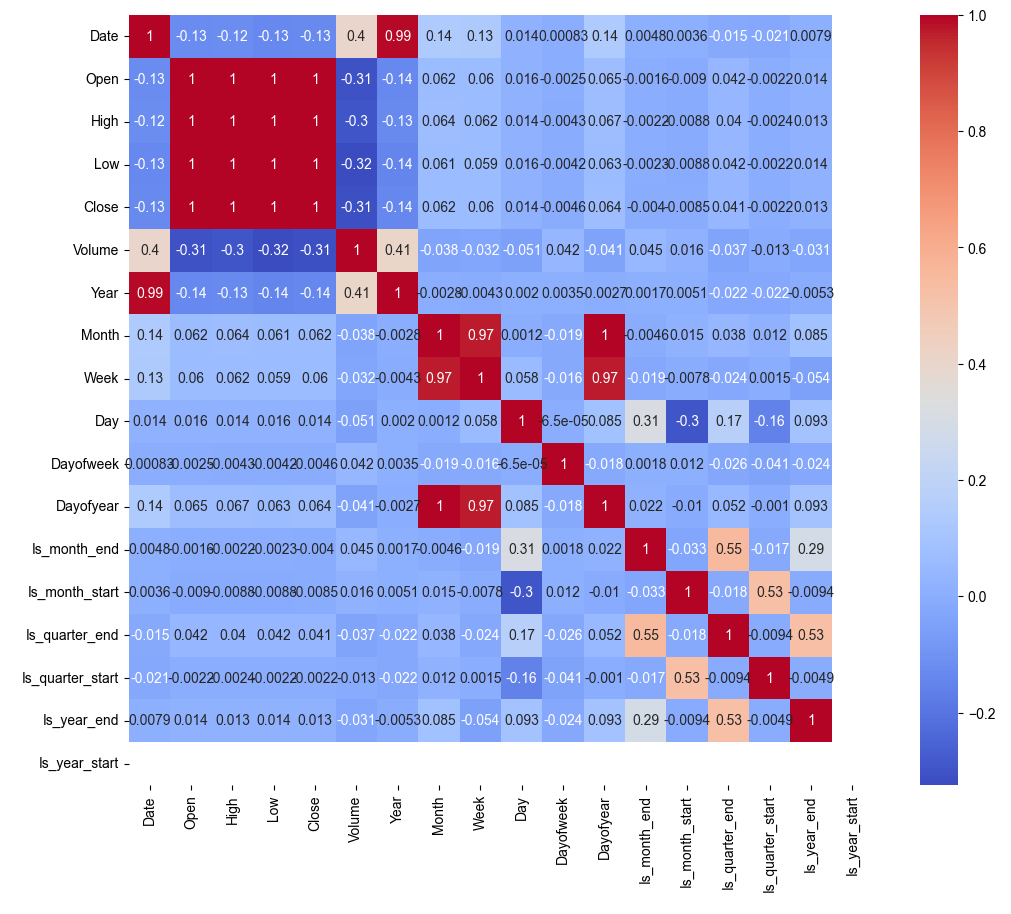

In [7]:
# create a heatmap to see the correlation between the features to the target variable, 'Close'
corr = sub_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
sns.set(font_scale=0.7)
plt.show()


In [8]:
sub_df['Daily Return'] = 100 * ((sub_df['Close'] / sub_df['Close'].shift(1)) - 1)
sub_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Daily Return
0,2013-01-02,49.02,49.69,49.00,49.68,8925500.0,2013,1,1,2,2,2,False,False,False,False,False,False,NaN
1,2013-01-03,49.55,49.80,49.43,49.78,6082200.0,2013,1,1,3,3,3,False,False,False,False,False,False,0.201288
2,2013-01-04,49.85,50.10,49.66,49.99,5615700.0,2013,1,1,4,4,4,False,False,False,False,False,False,0.421856
3,2013-01-07,49.63,50.04,49.44,50.03,5178100.0,2013,1,2,7,0,7,False,False,False,False,False,False,0.080016
4,2013-01-08,49.94,50.16,49.68,49.85,4708000.0,2013,1,2,8,1,8,False,False,False,False,False,False,-0.359784


meam = 0.03235060398417799, std dev = 1.3745108513747795


Text(0, 0.5, 'probability density')

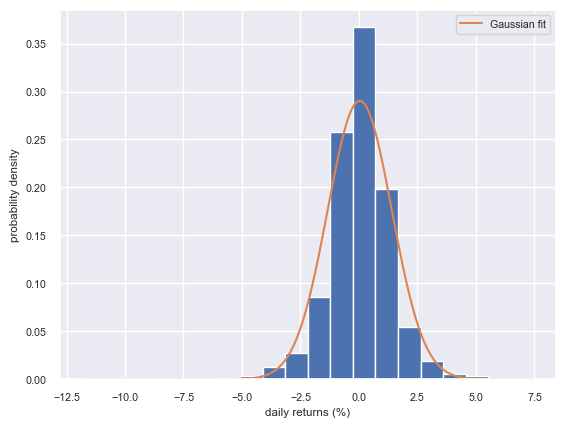

In [9]:
import math
mu = sub_df['Daily Return'].mean()
std = sub_df['Daily Return'].std()
x = np.arange(sub_df['Daily Return'].min(), sub_df['Daily Return'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("meam = " + str(mu) + ", std dev = " + str(std))

# Plot histogram of daily return
ax = sub_df['Daily Return'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax)
plt.legend(['Gaussian fit'])
plt.xlabel('daily returns (%)')
plt.ylabel('probability density')

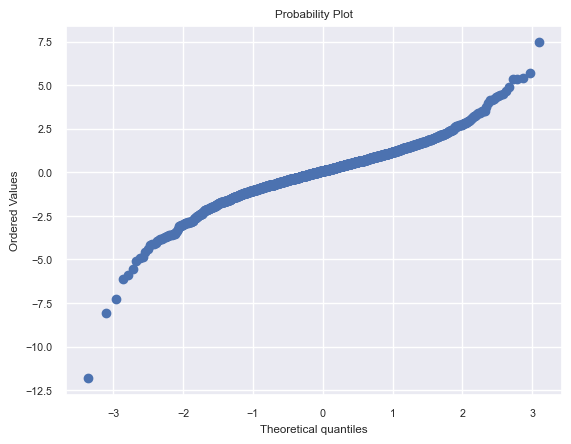

In [10]:
import scipy.stats as stats
import pylab

# Plot QQ plot of daily return
stats.probplot(sub_df['Daily Return'], dist="norm", plot=pylab)
pylab.show()

# 3. Data Validation

In [11]:
# Check null values
sub_df.isnull().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Year                0
Month               0
Week                0
Day                 0
Dayofweek           0
Dayofyear           0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
Daily Return        1
dtype: int64

> 1 null value in `Daily Return` is normal because the first day doesn't have return.

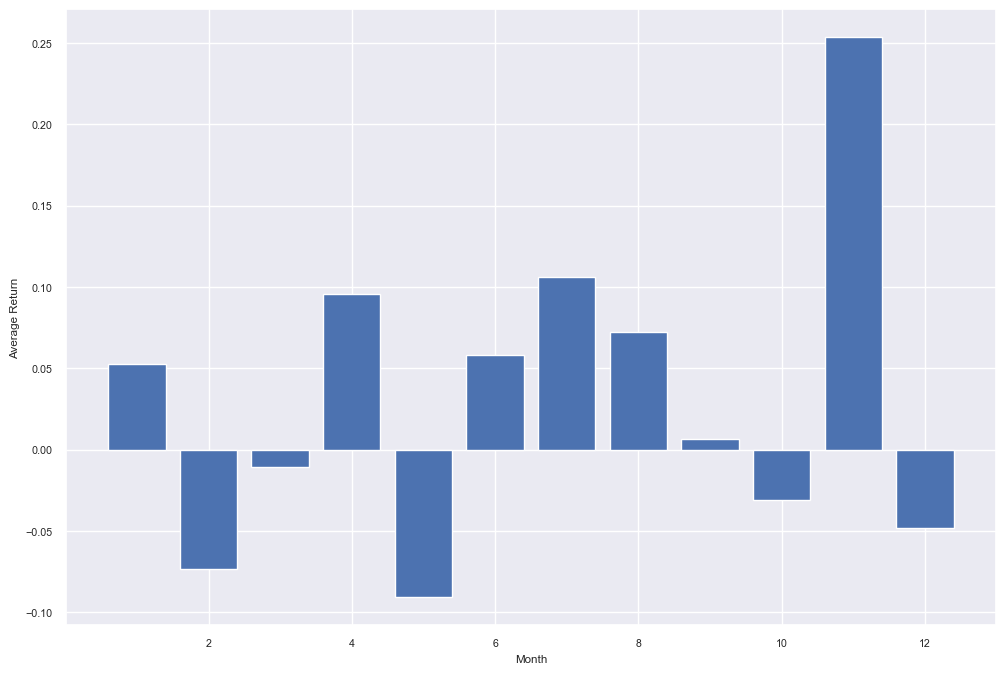

In [12]:
# Compute average return for each month
avg_return = sub_df.groupby('Month')['Daily Return'].mean()

# Create a bar plot of average return for each month
plt.figure(figsize=(12,8))
plt.bar(avg_return.index, avg_return.values)
plt.xlabel('Month')
plt.ylabel('Average Return')
plt.show()

In [13]:
# split into train, validation and test set
train_df = sub_df[(sub_df['Date'] >= '2013-01-01') & (sub_df['Date'] <= '2016-12-31')].reset_index(drop=True)
valid_df = sub_df[(sub_df['Date'] >= '2017-01-01') & (sub_df['Date'] <= '2017-12-31')].reset_index(drop=True)
test_df = sub_df[(sub_df['Date'] >= '2018-01-01') & (sub_df['Date'] <= '2018-12-31')].reset_index(drop=True)
print('train_df:', len(train_df), 'valid_df:', len(valid_df), 'test_df:', len(test_df))

train_df: 1008 valid_df: 251 test_df: 251


# Functions

## Function: Pred_XGBoost function

In [14]:
def pred_xgboost(model, X_test_ex_lags, N, H, prev_targets):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_lags     : features of the test set, excluding the daily_ret lags
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_targets.copy()

    for n in range(H):
        
        # Create the features dataframe
        X = X_test_ex_lags[n:n+1].copy()
        for n in range(N,0,-1):
            X['Daily Return_lag_'+str(n)] = [forecast[-n]]
        X = pd.DataFrame(X)
             
        # Do prediction
        est = model.predict(X)
        
        # Concatenate the prediction
        forecast = np.concatenate([forecast, est])
           
    return forecast[-H:]

## Functions: Error Metrics

In [15]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_wape(y_true, y_pred): 
    """
    Compute weighted absolute percentage error (WAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return sum(np.abs(y_true - y_pred)) / sum(y_true) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

## Function: Train Pred Eval Model

In [16]:
from xgboost import XGBRegressor
def train_pred_eval_model(X_train,
                          y_train,
                          X_test_ex_lags,
                          y_test_adj_close,
                          prev_val,
                          prev_targets,
                          N,
                          H,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, and do evaluation
    Use XGBoost here.
    Inputs
        X_train            : features for training
        y_train            : target for training
        X_test_ex_lags     : features of the test set, excluding the daily_ret lags
        y_test_adj_close   : target for test. This is adjusted close, not daily returns
        prev_val           : if predict at time t, this is the adj_close value at t-1
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                        #  seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
     
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_lags, N, H, prev_targets)
    
    # Convert back to price
    est_adj_close = []
    for n in range(H):
        prev_val = (est[n]/100+1)*prev_val
        est_adj_close.append(prev_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test_adj_close, est_adj_close)
    mape = get_mape(y_test_adj_close, est_adj_close)
    mae = get_mae(y_test_adj_close, est_adj_close)
    
    return rmse, mape, mae, est_adj_close, model.feature_importances_


## Function: Add lag data

In [17]:
def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

## Function: Run Model + Produce Metric Result

In [18]:
pred_day = 1470                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 7                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = len(train_df)             # Use 4 years of data as train set. Note there are about 252 trading days in a year
val_size = len(valid_df)                 # Use 1 year of data as validation set
train_val_size = train_size + val_size
train_val = sub_df[pred_day - train_val_size:pred_day].copy()
N = 21                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [19]:
# get the length of train, validation and test set
print('train_df:', train_size, 'valid_df:', val_size, 'test_df:', len(test_df), 'train + val', train_val_size)

train_df: 1008 valid_df: 251 test_df: 251 train + val 1259


In [20]:
def get_error_metrics(df,
                      train_size,
                      target,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        target             : e.g. 'daily_ret'
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, [target])
    
    # Get list of features
    features_ex_lags = [
        'Month',
        'Week',
        'Day',
        'Dayofweek',
        'Dayofyear',
        'Is_month_end',
        'Is_month_start',
        'Is_quarter_end',
        'Is_quarter_start',
        'Is_year_end'
    ]
    features = features_ex_lags # features contain all features, including lag features
    for n in range(N,0,-1):
        features.append(target+"_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train = train[features]
        y_train = train[target]
        X_test_ex_lags = test[features_ex_lags]
        y_test_adj_close = test['Close']
        prev_val = float(train['Close'][-1:])
        prev_targets = train[-N:][target].to_numpy()
            
        rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
                                                        y_train,
                                                        X_test_ex_lags,
                                                        y_test_adj_close,
                                                        prev_val,
                                                        prev_targets,
                                                        N,
                                                        H,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict, feature_importances, features

# Run Prediction for 21 day horizon

In [23]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict, _, _ = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'Daily Return',
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f" % mae_bef_tuning)

RMSE = 2.602
MAPE = 3.294%
MAE = 2.290


In [24]:
import plotly.graph_objects as go
import plotly.offline as py

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train_df['Date'], 
                         y=train_df['Close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=valid_df['Date'], 
                         y=valid_df['Close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test_df['Date'], 
                         y=test_df['Close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['Date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='Price (USD)'),
                  xaxis=dict(title='Date'))
fig.update_xaxes(range=[valid_df['Date'].min(), valid_df['Date'].max()])
fig.update_yaxes(range=[valid_df['Close'].min(), valid_df['Close'].max()])
py.iplot(fig, filename='StockPricePrediction_v3_xgboost_val_' + str(pred_day))